In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)


False
None


In [9]:
!pip install tonic --quiet

In [11]:
import tonic
import torchvision

sensor_size = tonic.datasets.POKERDVS.sensor_size
frame_transform = tonic.transforms.ToFrame(sensor_size=sensor_size, time_window=1000)

trainset = tonic.datasets.POKERDVS(save_to="./data", train=True)
testset = tonic.datasets.POKERDVS(
    save_to="./data", transform=frame_transform, train=False
)

In [12]:
events = trainset[0][0]
events

array([(    0,  5,  3, 1), (   89, 28,  3, 1), (   97,  5,  5, 1), ...,
       (24795,  3, 21, 1), (24796, 18, 30, 1), (24797, 10, 20, 1)],
      dtype=[('t', '<i8'), ('x', '<i8'), ('y', '<i8'), ('p', '<i8')])

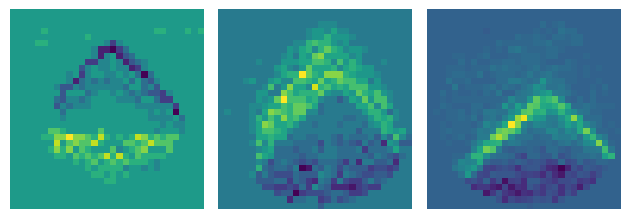

In [15]:
tonic.utils.plot_event_grid(events)

In [17]:
trainset[0][1]

3

In [19]:
# reduce this number if you run out of GPU memory
BATCH_SIZE = 32

# add sparse transform to trainset, previously omitted because we wanted to look at raw events
trainset.transform = frame_transform

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    collate_fn=tonic.collation.PadTensors(batch_first=False),
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    collate_fn=tonic.collation.PadTensors(batch_first=False),
    shuffle=False,
)

In [21]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell

# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState

from typing import NamedTuple


class SNNState(NamedTuple):
    lif0: LIFState
    readout: LIState


class SNN(torch.nn.Module):
    def __init__(
        self,
        input_features,
        hidden_features,
        output_features,
        tau_syn_inv,
        tau_mem_inv,
        record=False,
        dt=1e-3,
    ):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(
                alpha=100,
                v_th=torch.as_tensor(0.3),
                tau_syn_inv=tau_syn_inv,
                tau_mem_inv=tau_mem_inv,
            ),
            dt=dt,
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record

    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z=torch.zeros(seq_length, batch_size, self.hidden_features),
                    v=torch.zeros(seq_length, batch_size, self.hidden_features),
                    i=torch.zeros(seq_length, batch_size, self.hidden_features),
                ),
                LIState(
                    v=torch.zeros(seq_length, batch_size, self.output_features),
                    i=torch.zeros(seq_length, batch_size, self.output_features),
                ),
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts, :] = s1.z
                self.recording.lif0.v[ts, :] = s1.v
                self.recording.lif0.i[ts, :] = s1.i
                self.recording.readout.v[ts, :] = so.v
                self.recording.readout.i[ts, :] = so.i
            voltages += [vo]

        return torch.stack(voltages)

/Users/sophie/miniconda3/envs/neuromorphic_env/lib/python3.9/site-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
/Users/sophie/miniconda3/envs/neuromorphic_env/lib/python3.9/site-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFState'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
/Users/sophie/miniconda3/envs/neuromorphic_env/lib/python3.9/site-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFFeedForwardState'> is a subclass of `collections.namedtuple`, which is al

In [22]:
example_snn = SNN(
    np.product(trainset.sensor_size),
    100,
    len(trainset.classes),
    tau_syn_inv=torch.tensor(1 / 1e-2),
    tau_mem_inv=torch.tensor(1 / 1e-2),
    record=True,
    dt=1e-3,
)

frames, target = next(iter(train_loader))

frames[:, :1].shape

torch.Size([29, 1, 2, 35, 35])

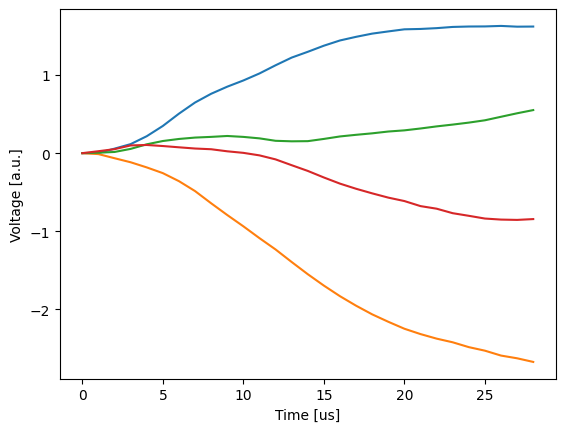

In [25]:
example_readout_voltages = example_snn(frames[:, :1])
voltages = example_readout_voltages.squeeze(1).detach().numpy()

plt.plot(voltages)
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [us]")
plt.show()

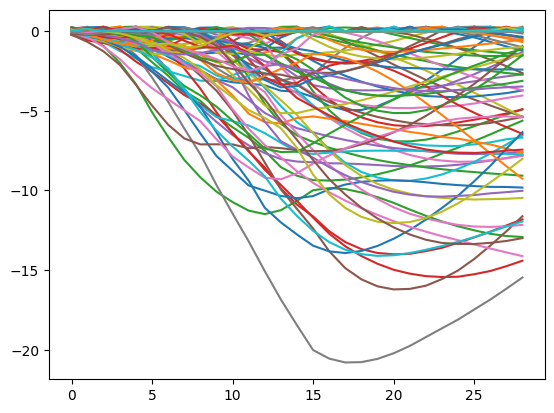

In [27]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

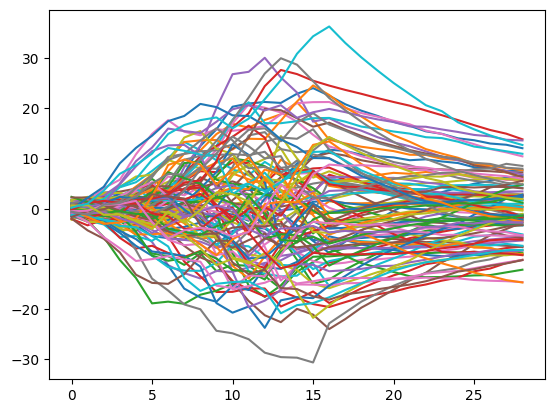

In [29]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

In [31]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y


class Model(torch.nn.Module):
    def __init__(self, snn, decoder):
        super(Model, self).__init__()
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [33]:
LR = 0.002
INPUT_FEATURES = np.product(trainset.sensor_size)
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = len(trainset.classes)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
        tau_syn_inv=torch.tensor(1 / 1e-2),
        tau_mem_inv=torch.tensor(1 / 1e-2),
    ),
    decoder=decode,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=2450, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(100.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.3000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=4, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [35]:
from tqdm.notebook import tqdm, trange


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device), torch.LongTensor(target).to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

In [37]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), torch.LongTensor(target).to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [45]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

torch.autograd.set_detect_anomaly(True)

EPOCHS = 15

for epoch in trange(EPOCHS):
    print(f"Starting Epoch {epoch+1}/{EPOCHS}")
    training_loss, mean_loss = train(model, DEVICE, train_loader, optimizer, epoch)
    print(f"Finished training for Epoch {epoch+1}")
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    print(f"Finished testing for Epoch {epoch+1}")
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    print(f"Completed Epoch {epoch+1}")

print(f"final accuracy: {accuracies[-1]}")

  0%|          | 0/15 [00:00<?, ?it/s]

Starting Epoch 1/15


  0%|          | 0/2 [00:00<?, ?it/s]

Finished training for Epoch 1
Finished testing for Epoch 1
Completed Epoch 1
Starting Epoch 2/15


  0%|          | 0/2 [00:00<?, ?it/s]

Finished training for Epoch 2
Finished testing for Epoch 2
Completed Epoch 2
Starting Epoch 3/15


  0%|          | 0/2 [00:00<?, ?it/s]

Finished training for Epoch 3
Finished testing for Epoch 3
Completed Epoch 3
Starting Epoch 4/15


  0%|          | 0/2 [00:00<?, ?it/s]

Finished training for Epoch 4
Finished testing for Epoch 4
Completed Epoch 4
Starting Epoch 5/15


  0%|          | 0/2 [00:00<?, ?it/s]

Finished training for Epoch 5
Finished testing for Epoch 5
Completed Epoch 5
Starting Epoch 6/15


  0%|          | 0/2 [00:00<?, ?it/s]

Finished training for Epoch 6
Finished testing for Epoch 6
Completed Epoch 6
Starting Epoch 7/15


  0%|          | 0/2 [00:00<?, ?it/s]

Finished training for Epoch 7
Finished testing for Epoch 7
Completed Epoch 7
Starting Epoch 8/15


  0%|          | 0/2 [00:00<?, ?it/s]

Finished training for Epoch 8
Finished testing for Epoch 8
Completed Epoch 8
Starting Epoch 9/15


  0%|          | 0/2 [00:00<?, ?it/s]

Finished training for Epoch 9
Finished testing for Epoch 9
Completed Epoch 9
Starting Epoch 10/15


  0%|          | 0/2 [00:00<?, ?it/s]

Finished training for Epoch 10
Finished testing for Epoch 10
Completed Epoch 10
Starting Epoch 11/15


  0%|          | 0/2 [00:00<?, ?it/s]

Finished training for Epoch 11
Finished testing for Epoch 11
Completed Epoch 11
Starting Epoch 12/15


  0%|          | 0/2 [00:00<?, ?it/s]

Finished training for Epoch 12
Finished testing for Epoch 12
Completed Epoch 12
Starting Epoch 13/15


  0%|          | 0/2 [00:00<?, ?it/s]

Finished training for Epoch 13
Finished testing for Epoch 13
Completed Epoch 13
Starting Epoch 14/15


  0%|          | 0/2 [00:00<?, ?it/s]

Finished training for Epoch 14
Finished testing for Epoch 14
Completed Epoch 14
Starting Epoch 15/15


  0%|          | 0/2 [00:00<?, ?it/s]

Finished training for Epoch 15
Finished testing for Epoch 15
Completed Epoch 15
final accuracy: 100.0


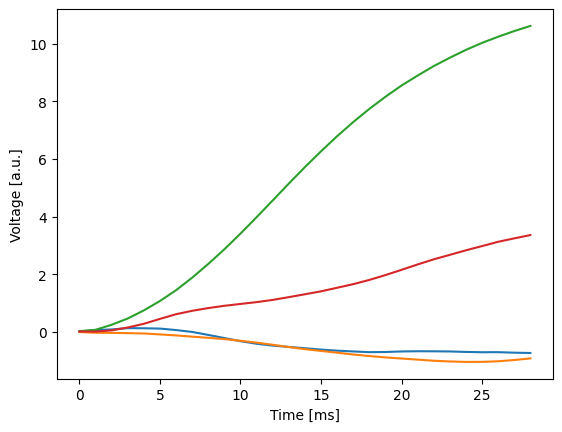

In [47]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_snn = model.snn.to(DEVICE)
frames = frames.to(DEVICE)
trained_readout_voltages = trained_snn(frames[:, :1])

plt.plot(trained_readout_voltages.squeeze(1).cpu().detach().numpy())
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()


---